# BERT for Document Classification

## Preamble

In [1]:
# Preamble
import time, random
import re, string
import os, sys
import math
import json

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

from tqdm import tqdm

from IPython.display import clear_output

DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
BATCH_SIZE = 8
NUM_CLASSES = 2
MSL = 256

In [2]:
!pip install tqdm boto3 requests regex sentencepiece sacremoses
clear_output()

## Load pretrained models and utils

In [3]:
# Tokenizer
tokenizer = torch.hub.load('huggingface/pytorch-transformers', 'tokenizer', 'bert-base-uncased')
# Pretrained model
model = torch.hub.load('huggingface/pytorch-transformers', 'modelForSequenceClassification', 'bert-base-uncased', num_labels= NUM_CLASSES)
model.to(DEVICE)

/opt/conda/lib/python3.10/site-packages/torch/hub.py:294: UserWarning: You are about to download and run code from an untrusted repository. In a future release, this won't be allowed. To add the repository to your trusted list, change the command to {calling_fn}(..., trust_repo=False) and a command prompt will appear asking for an explicit confirmation of trust, or load(..., trust_repo=True), which will assume that the prompt is to be answered with 'yes'. You can also use load(..., trust_repo='check') which will only prompt for confirmation if the repo is not already trusted. This will eventually be the default behaviour
  warnings.warn(
Downloading: "https://github.com/huggingface/pytorch-transformers/zipball/main" to /root/.cache/torch/hub/main.zip


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Using cache found in /root/.cache/torch/hub/huggingface_pytorch-transformers_main


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

In [4]:
# Verify model architecture
print('########### ARCHITECTURE ###########')
print(model)
print('########### CONFIG ###########')
print(model.config)

########### ARCHITECTURE ###########
BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (Lay

## Refining tokenizer for finetuning
The implementation is adapted from: https://www.kaggle.com/code/jaskaransingh/bert-fine-tuning-with-pytorch#4.-Train-Our-Classification-Model

In [5]:
def encode_sentence(sent, max_length= MSL):
    # `encode_plus` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    #   (5) Pad or truncate the sentence to `max_length`
    #   (6) Create attention masks for [PAD] tokens.
    encoded_dict = tokenizer.encode_plus(
                        sent,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = max_length,   # Pad & truncate all sentences.
                        pad_to_max_length = True,
                        return_attention_mask = True,   # Construct attn. masks.
                        return_tensors = 'pt',     # Return pytorch tensors.
                   )
    
    return encoded_dict['input_ids'], encoded_dict['attention_mask']

In [6]:
s = 'The restaurant is extraordinary!'
inp, mask = encode_sentence(s, 10)
logits = model(inp.to(DEVICE), attention_mask = mask.to(DEVICE)).logits
probs = nn.Softmax(dim= 1)(logits)
print(probs)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:2688: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


tensor([[0.4191, 0.5809]], device='cuda:0', grad_fn=<SoftmaxBackward0>)


## Dataset and Dataloaders

In [7]:
# NLP Dataset
class NLPDataset(Dataset):
    def __init__(self, df, df_sort= False):
        self.df = df
        if df_sort:
            self.sort_df_by_txt_len()
    
    def sort_df_by_txt_len(self):
        len_list = [-len(self.df.iloc[i]['text']) for i in range(len(self.df))]
        self.df = self.df.iloc[np.argsort(len_list)]
    
    def __len__(self):
        return len(self.df)

    def label_pipeline(self, x):
        return int(x)
    
    def __getitem__(self, idx):
        txt = self.df.iloc[idx]['text']
        
        label = self.label_pipeline(self.df.iloc[idx]['label'])
        
        return (txt, label)
    
def collate_bert(batch):
    labels = []
    texts = []
    masks = []
    for text, label in batch:
        input_ids, attn_mask = encode_sentence(text)
        texts.append(input_ids.reshape(-1,))
        masks.append(attn_mask.reshape(-1,))
        labels.append(torch.tensor(label, dtype= torch.int64))
        
    labels = torch.stack(labels)
    masks = torch.stack(masks)
    texts = torch.stack(texts)
    
    return texts, masks, labels

In [8]:
# # YELP Preparation
# data_file = open("/kaggle/input/yelp-dataset/yelp_academic_dataset_review.json")
# data = []

# # cnt = 1569264 # Size of YELP 2015 dataset
# cnt = 100000

# for line in data_file:
#     data.append(json.loads(line))
#     cnt -= 1
#     if cnt == 0:
#         break
    
# data_file.close()
# df = pd.DataFrame(data)

# print("Number of datapoints:", len(df))
# df.head()

# # R52 Preparation
# train_ds = pd.read_csv('/kaggle/input/smolcsv/r52-train-stemmed.csv')
# val_ds = pd.read_csv('/kaggle/input/smolcsv/r52-dev-stemmed.csv')
# test_ds = pd.read_csv('/kaggle/input/smolcsv/r52-test-stemmed.csv')

# ds = pd.concat([train_ds, val_ds, test_ds])

# print('Size of data corpus:', len(ds))
# ds.head()

# MR Preparation
df = pd.read_csv('/kaggle/input/smolcsv/MR.csv')

print("Number of datapoints:", len(df))
df.head()

Number of datapoints: 10662


,Unnamed: 0,text,Sentiment,label
0,0,the rock is destined to be the 21st century's ...,positive,1
1,1,"the gorgeously elaborate continuation of "" the...",positive,1
2,2,effective but too-tepid biopic,positive,1
3,3,if you sometimes like to go to the movies to h...,positive,1
4,4,"emerges as something rare , an issue movie tha...",positive,1


In [9]:
# MR preparation
df_size = len(df)
idx = [x for x in range(df_size)]
random.Random(555).shuffle(idx)

train_num = int(df_size * 0.8)
val_num = int(df_size * 0.1)
test_num = int(df_size * 0.1)

# print(train_num, val_num, test_num)

train_idx = idx[:train_num]
val_idx = idx[train_num : (train_num + val_num)]
test_idx = idx[(train_num + val_num) : ]

train_df = df.iloc[train_idx]
val_df = df.iloc[val_idx]
test_df = df.iloc[test_idx]

# train_df = pd.read_csv('/kaggle/input/smolcsv/r52-train-stemmed.csv')
# val_df = pd.read_csv('/kaggle/input/smolcsv/r52-dev-stemmed.csv')
# test_df = pd.read_csv('/kaggle/input/smolcsv/r52-test-stemmed.csv')

print('Size of trainset:', len(train_df))
print('Size of valset:', len(val_df))
print('Size of testset:', len(test_df))

Size of trainset: 8529
Size of valset: 1066
Size of testset: 1067


In [10]:
# Dataset, Dataloader
trainset = NLPDataset(train_df)
valset = NLPDataset(val_df)
testset = NLPDataset(test_df)

trainloader = DataLoader(trainset, batch_size= BATCH_SIZE, 
                         shuffle= True, pin_memory= True, collate_fn= collate_bert)

valloader = DataLoader(valset, batch_size= BATCH_SIZE, 
                         shuffle= True, pin_memory= True, collate_fn= collate_bert)

testloader = DataLoader(testset, batch_size= BATCH_SIZE, 
                         shuffle= True, pin_memory= True, collate_fn= collate_bert)

for batch in trainloader:
    texts, masks, labels = batch
    print("Shape of Texts:", texts.shape)
    print("Shape of Labels:", labels.shape)
    print("Length of Masks:", masks.shape)
    break

Shape of Texts: torch.Size([8, 256])
Shape of Labels: torch.Size([8])
Length of Masks: torch.Size([8, 256])


/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:2688: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


## Training configs

In [11]:
# Training configs
LR = 2e-5

EPOCHS = 20
ITER = EPOCHS * len(trainloader)

OPTIMIZER = torch.optim.Adam(model.parameters(), lr= LR)
# OPTIMIZER = torch.optim.SGD(model.parameters(), lr= LR, momentum= 0.9, nesterov= True)

SCHEDULER = torch.optim.lr_scheduler.CosineAnnealingLR(OPTIMIZER, T_max = ITER)
# SCHEDULER = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(OPTIMIZER, T_0= 25, T_mult = 1, eta_min= 0)

LOSS_FN = nn.CrossEntropyLoss()
RECORD = 0.0

In [12]:
# Train procedures
def test(testloader, model, loss_fn):
    model.eval()
    test_loss = 0
    correct = 0
    bcnt = 0
    cnt = 0
    
    for i, batch in enumerate(testloader):
        tmp_loss = 0
        cnt += 1
        
        texts, masks, labels = batch
        texts, masks, labels = texts.to(DEVICE), masks.to(DEVICE), labels.to(DEVICE) 
        logits = model(texts, attention_mask= masks).logits
        
        tmp_loss += loss_fn(logits, labels).item()
        correct += (logits.argmax(1) == labels).type(torch.float).sum().item()
        tmp_loss /= len(batch)
        test_loss += tmp_loss
        
    test_loss /= len(testloader)
    accuracy = correct / len(testloader.dataset)
    
    return test_loss, accuracy

def train(trainloader, valloader, model, optimizer, scheduler, loss_fn, val_freq):
    global RECORD
    model.train()
    tloss = []
    cur_acc = 0
    for i, batch in enumerate(trainloader):
        loss = 0
        texts, masks, labels = batch
        texts, masks, labels = texts.to(DEVICE), masks.to(DEVICE), labels.to(DEVICE) 
        logits = model(texts, attention_mask= masks).logits
        loss += loss_fn(logits, labels)
        loss /= len(batch)
        
        if val_freq > 0 and i % val_freq == 0:
            tloss.append(loss.cpu().detach().numpy())
            model.eval()
            val_loss, val_acc = test(valloader, model, loss_fn)
            model.train()
            print(f'Iter {i}, loss = {tloss[-1]}, val_acc = {val_acc}')
            if RECORD < val_acc:
                RECORD = val_acc
                print('Saving model...')
                torch.save(model.state_dict(), f'BERT_best.pth')
        
        tloss.append(loss.cpu().detach().numpy())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
#         scheduler.step()
        
    model.eval()
    val_loss, val_acc = test(valloader, model, loss_fn)
    model.train()
    print(f'Iter {i}, loss = {tloss[-1]}, val_acc = {val_acc}')
    if RECORD < val_acc:
        RECORD = val_acc
        print('Saving model...')
        torch.save(model.state_dict(), f'BERT_{val_acc*100}.pth')
        torch.save(model.state_dict(), f'BERT_best.pth')
        
    return tloss

Epoch 0 starts.
Iter 0, loss = 0.25415849685668945, val_acc = 0.50187617260788
Saving model...
Iter 100, loss = 0.0363243967294693, val_acc = 0.8217636022514071
Saving model...
Iter 200, loss = 0.1195949912071228, val_acc = 0.8339587242026266
Saving model...
Iter 300, loss = 0.03586823493242264, val_acc = 0.8198874296435272
Iter 400, loss = 0.16586628556251526, val_acc = 0.8555347091932458
Saving model...
Iter 500, loss = 0.04544764757156372, val_acc = 0.8442776735459663
Iter 600, loss = 0.22303619980812073, val_acc = 0.8264540337711069
Iter 700, loss = 0.0935974270105362, val_acc = 0.8461538461538461
Iter 800, loss = 0.0636858344078064, val_acc = 0.8461538461538461
Iter 900, loss = 0.20799559354782104, val_acc = 0.8395872420262664
Iter 1000, loss = 0.14302322268486023, val_acc = 0.849906191369606
Iter 1066, loss = 0.009557509794831276, val_acc = 0.8461538461538461
Epoch 0: LOSS = 0.12905163622110502, VAL-ACC = 0.8461538461538461
Epoch 1 starts.
Iter 0, loss = 0.07175993174314499, val_

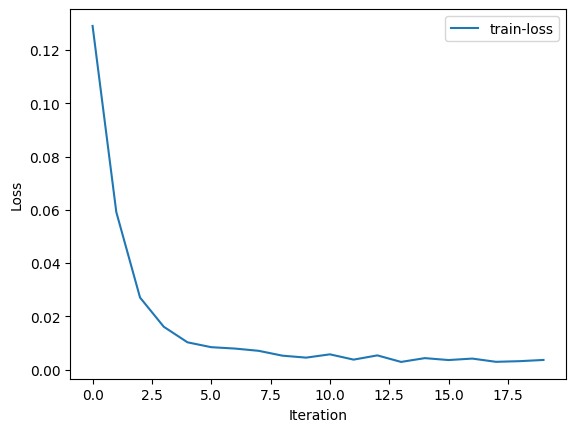

In [13]:
# TRAINING
iter_loss = []
epoch_loss = []
best_acc = 0

for t in range(EPOCHS):
    print(f'Epoch {t} starts.')
    tloss = train(trainloader, valloader, model, OPTIMIZER, SCHEDULER, LOSS_FN, 100)
    val_loss, val_acc = test(valloader, model, LOSS_FN)
    
    iter_loss = iter_loss + tloss
    epoch_loss.append(sum(tloss) / len(tloss))
    
    print(f'Epoch {t}: LOSS = {epoch_loss[-1]}, VAL-ACC = {val_acc}')
    
torch.save(model.state_dict(), f'BERT_last.pth')
    
fig, axes = plt.subplots()
axes.plot(epoch_loss, label = 'train-loss')
axes.legend()
axes.set_xlabel('Iteration')
axes.set_ylabel('Loss')
plt.show()

In [14]:
_, val_acc = test(testloader, model, LOSS_FN)
print(f'(LAST) Test accuracy: {val_acc}')

(LAST) Test accuracy: 0.8603561387066542


In [15]:
model.load_state_dict(torch.load('BERT_best.pth', map_location= DEVICE))
_, val_acc = test(testloader, model, LOSS_FN)
print(f'(BEST) Test accuracy: {val_acc}')

(BEST) Test accuracy: 0.8641049671977507
